# Investigation of SEDs of ZFourge Templates in UVJ Colour Space
This particular code will be used to investigate the ZFOURGE galaxies using some of michael's code to transform ZFOURGE photometry into SEDs. The SEDs will then be plotted in UVJ colour space to investigate the distribution of the ZFOURGE galaxies in this space. This code is intended to be used to pick a few galaxies in each reigon of the UVJ space, which will then be investigated in further detail.

In [48]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import seaborn as sns
import os
from astropy.io import fits

In [49]:
def read_zfourge_data(fieldname, folderpath): # Define a function to read in zfourge data, this will be added to the helper package later
    # Dictionary to read from
    zfourge_fields = {
    'CDFS': ['zf_cdfs.fits', 'zf_cdfs_rest.fits', 'zf_cdfs_eazy.fits', 'zf_cdfs_sfr.fits'],
    'COSMOS': ['zf_cosmos.fits', 'zf_cosmos_rest.fits', 'zf_cosmos_eazy.fits', 'zf_cosmos_sfr.fits'],
    'UDS': ['zf_uds.fits', 'zf_uds_rest.fits', 'zf_uds_eazy.fits', 'zf_uds_sfr.fits'],
}
    
    folder = folderpath
    
    # Construct file paths using os.path.join() to make it platform-independent
    catalog_file = os.path.join(folder, zfourge_fields[fieldname][0])
    rest_file = os.path.join(folder, zfourge_fields[fieldname][1])
    eazy_file = os.path.join(folder, zfourge_fields[fieldname][2])
    sfr_file = os.path.join(folder, zfourge_fields[fieldname][3])
    
    # Open the fits files
    catalog_fits = fits.open(catalog_file)
    rest_fits = fits.open(rest_file)
    sfr_fits = fits.open(sfr_file)
    
    # Read the files into DataFrames
    df = pd.DataFrame(np.array(catalog_fits[1].data).byteswap().newbyteorder()) 
    rest_df = pd.DataFrame(np.array(rest_fits[1].data).byteswap().newbyteorder())
    eazy_df = pd.DataFrame(np.array(fits.open(eazy_file)[1].data).byteswap().newbyteorder())
    sfr_df = pd.DataFrame(np.array(sfr_fits[1].data).byteswap().newbyteorder())
    
    
    # Rename the Seq column to id for consistency
    df.rename(columns={'Seq':'id'}, inplace=True)
    rest_df.rename(columns={'Seq':'id', 'FU':'U', 'e_FU':'eU', 'FV':'V', 'e_FV':'eV', 'FJ':'J','e_FJ':'eJ'}, inplace=True)
    eazy_df.rename(columns={'Seq':'id'}, inplace=True)
    sfr_df.rename(columns={'Seq':'id'}, inplace=True)
    
    
    # We now merge the two dataframes into one dataframe, adding a suffix _rest if columns clash
    #df = pd.merge(df, rest_df, on='id', suffixes=('', '_rest'))
    
    # we now merge rest and df into one
    #df = pd.concat([df, rest_df], axis=1)
    df = pd.merge(df, rest_df[['id', 'U', 'eU', 'V', 'eV', 'J','eJ']], on='id', suffixes=('_original', '_rest'))
    df = pd.merge(df, eazy_df[['id', 'zpk']], on='id', suffixes=('', '_eazy'))
    df = pd.merge(df, sfr_df[['id', 'lssfr', 'lmass']], on='id', suffixes=('', '_sfr'))
    
    
    # Create a new column to mark the field that this data is from
    df['field'] = fieldname
    
    # rename the number in the id column to be prefixed by the fieldname, this is to avoid confusion when merging dataframes
    df['id'] = fieldname + '_' + df['id'].astype(str)
    
    # return the created dataframe
    return df

In [50]:
zfourge_path = 'datasets/zfourge/'

# As we are only working with the ZFOURGE Survey, we will only read in the CDFS data
df = read_zfourge_data('CDFS', zfourge_path)

In [51]:
# Filter the data as necessay
# flux filtering, set a sigma value for the flux error ratio
sigma = 5

# optionally we can filter the data into fields
#field = 'CDFS'
#df = df[df['field'] == field].copy()

# filter for uvj colours, making sure that there isn't a flux below 0
df = df[(df['U'] > 0) & (df['V'] > 0) & (df['J'] > 0) & (df['eU'] > 0) & (df['eV'] > 0) & (df['eJ'] > 0) & (df['Use']==1)].copy()

# we also need to filter by the redshift, Z-fourge only has reliable accuracy for redshifts between 0.2 and 3.2 ~ potentially up to a redshift of 4
df = df[(df['zpk'] > 0.2) & (df['zpk'] < 3.2)].copy()



# Propogate errors from each of the fluxes to the UVJ diagram to a ratio of sigma

df = df[(df['U'] >= sigma * df['eU']) & (df['V'] >= sigma * df['eV']) & (df['J'] >= sigma * df['eJ'])].copy()

In [52]:
# We want to define a function to convert flux to absolute magnitude
def flux_to_mag(flux):
    ab_f = 25 - 2.5*np.log10(flux)
    return ab_f

In [53]:

# Create new columns for the magnitudes of each of the filters
df.loc[:, 'mag_U'] = flux_to_mag(df['U'])
df.loc[:, 'mag_V'] = flux_to_mag(df['V'])
df.loc[:, 'mag_J'] = flux_to_mag(df['J'])

# Likewise also create new columns of the converted errors to magnitudes
df.loc[:, 'e_mag_U'] = flux_to_mag(df['eU'])
df.loc[:, 'e_mag_V'] = flux_to_mag(df['eV'])
df.loc[:, 'e_mag_J'] = flux_to_mag(df['eJ'])

Now that we have our data filtered and cleaned, we can plot the UVJ diagram. 
The aim of this investigation is to choose a good selection of galaxies of which
the UVJ colours are indicative of quiscents, star-forming, and intermeidates.
Preferably with no AGN contamination.
and preferbably that are not chosen with particular bias
We can remove confirmed (by xray) AGN from the sample,
by way of michael's AGN candidates and also create functions to 
Explore different selection methods (using random choice, or a statistical selection method)

Importantly, confirm these selections with the ZFOURGE website and see if they have been catalogued in an astronomical database.

In [54]:
def categorise_uvj(df):
    id = df['id']
    x = df['mag_V'] - df['mag_J']
    y = df['mag_U'] - df['mag_V']

    # Plot the UVJ diagram
    plt.figure(figsize=(10, 10))

    xmax = 2.5
    ymax = 2.5
    xmin = -0.5
    ymin = 0

    # Set the plotting limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    # Define the points for a quiescent galaxy selection
    x_points = [-0.5, 0.85, 1.6, 1.6]
    y_points = [1.3, 1.3, 1.95, 2.5]

    # Plot the points
    plt.plot(x_points, y_points, linestyle='-')

    # Interpolate the y-value at x=1.2
    x_target = 1.2
    y_target = np.interp(x_target, x_points, y_points)

    # Plot the interpolated point, this separates everything on the right as dusty galaxies,
    # and everything on the left as star-forming galaxies
    plt.plot([x_target, x_target], [0, y_target], linestyle='--')

    quiescent_x = [-0.5, 0.85, 1.6, 1.6, xmin, xmin]
    quiescent_y = [1.3, 1.3, 1.95, 2.5, ymax, 1.3]
    # We want to make a wedge selection for the Quiescent Selection of Galaxies
    points = np.column_stack([x, y])
    verts = np.array([quiescent_x, quiescent_y]).T
    path = mpath.Path(verts)
    
    
    # Define the path for point selection
    #selected_path = mpath.Path([(2, 3), (6, 4), (8, 2), (2, 1), (2, 3)])  # Example path, replace with your own

    # Use path.contains_points to get a boolean array
    points_inside_selection = path.contains_points(np.column_stack([x, y]))
    
    
    
    dusty_condition = (points[:, 0] > x_target) & (~points_inside_selection)
    star_forming_condition = (points[:, 0] < x_target) & (~points_inside_selection)
    
    

    # Filter the DataFrame using the boolean array
    selected_df = df[points_inside_selection] # For quiescent, clean later
    
    
    # Mark dusty, and star-forming galaxies
    df.loc[dusty_condition, 'GalaxyType'] = 2
    df.loc[star_forming_condition, 'GalaxyType'] = 1
    
    
    
    
    print(selected_df)
    #print(unselected_df)
    
    # Now we can easily select the quiescent galaxies and set the galaxy type to quiescent - 0 or starforming 1.
    print(selected_df)
    selected_ids = selected_df['id']
    df.loc[df['id'].isin(selected_ids), 'GalaxyType'] = 0 # This is what makes the selection happen
    
    
    
    # Try do the same for the unselected galaxies, noting that the unselected galaxies with x and y > 1.2 are dusty galaxies, and the rest are star-forming galaxies
    #unselected_ids = unselected_df['id']
    
    
    
    
    # Sort the quiescent and non-quiescent galaxies
    quiescent_points = points[path.contains_points(points)]
    # Find the points from here to categorise dusty, and star-forming galaxies
    non_quiescent_points = points[~path.contains_points(points)]
    dusty_galaxies_points = non_quiescent_points[non_quiescent_points[:, 0] > x_target]
    star_forming_galaxies_points = non_quiescent_points[non_quiescent_points[:, 0] < x_target]
    
    
    #print(non_quiescent_points[0][0])
    
    #print(y)
    # Plot the selected points
    #plt.scatter(x, y, s=3, alpha=0.5, label='Not Quiescent Selection')
    plt.scatter(quiescent_points[:, 0], quiescent_points[:, 1], c='r', s=3, alpha=0.5, label='Quiescent Selection')
    plt.scatter(dusty_galaxies_points[:, 0], dusty_galaxies_points[:, 1], c='g', s=3, alpha=0.5, label='Dusty Galaxies')
    plt.scatter(star_forming_galaxies_points[:, 0], star_forming_galaxies_points[:, 1], c='b', s=3, alpha=0.5, label='Star Forming Galaxies')

    plt.xlabel('Restframe V-J [Mag]')
    plt.ylabel('Restframe U-V [Mag]')
    plt.title('UVJ Diagram for the CDFS field')
    plt.legend()
    plt.show()
    return df

       recno          id      xpos      ypos    RAJ2000    DEJ2000  SE  \
6438    6426   CDFS_6426  4655.385  2324.571  53.072933 -27.878326   0   
6694    6681   CDFS_6681  4346.676  2419.136  53.087486 -27.874392   0   
7259    7234   CDFS_7234  4553.939  2541.882  53.077717 -27.869274   3   
7482    7457   CDFS_7457  4774.748  2522.375  53.067310 -27.870083   3   
7570    7544   CDFS_7544  4338.467  2547.291  53.087875 -27.869051   0   
...      ...         ...       ...       ...        ...        ...  ..   
29948  30220  CDFS_30220  4029.372  7352.167  53.102482 -27.668852   3   
30048  30004  CDFS_30004  3099.489  7219.256  53.146229 -27.674389   0   
30245  30244  CDFS_30244  3222.185  7352.918  53.140457 -27.668821   0   
30542  30540  CDFS_30540  2669.843  7538.817  53.166439 -27.661070   0   
30718  30718  CDFS_30718  3080.672  7526.409  53.147110 -27.661591   3   

       isoArea     FKsap  e_FKsap  ...     zpk      lssfr  lmass  field  \
6438     114.0   4.54853  0.08025  .

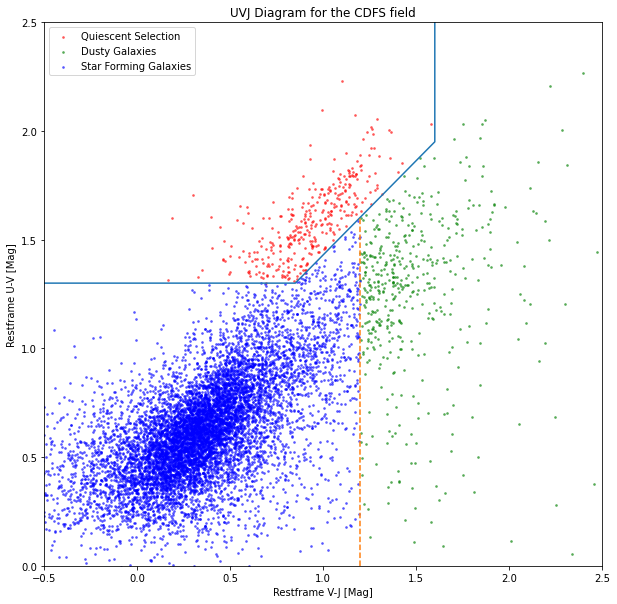

,recno,id,xpos,ypos,RAJ2000,DEJ2000,SE,isoArea,FKsap,e_FKsap,...,lssfr,lmass,field,mag_U,mag_V,mag_J,e_mag_U,e_mag_V,e_mag_J,GalaxyType
5750,5746,CDFS_5746,4778.412,2191.809,53.067131,-27.883856,2,362.0,2.69849,0.09566,...,-8.71,10.56,CDFS,23.505707,22.945962,22.487886,28.189118,26.621650,30.461820,1.0
5865,5860,CDFS_5860,4916.620,2228.198,53.060615,-27.882338,3,247.0,8.31529,0.10266,...,-9.20,10.91,CDFS,24.430817,23.242432,22.162176,28.036727,28.086313,27.366353,1.0
5885,5880,CDFS_5880,4918.070,2205.127,53.060547,-27.883299,3,134.0,3.12787,0.10767,...,-9.05,10.10,CDFS,25.104508,24.260533,23.459063,28.526539,28.795784,27.973950,1.0
5892,5886,CDFS_5886,4903.505,2218.433,53.061234,-27.882744,3,182.0,3.09289,0.10266,...,-8.65,9.41,CDFS,24.612594,24.031646,23.624230,30.320615,30.149472,29.982103,1.0
5936,5928,CDFS_5928,4865.992,2198.946,53.063004,-27.883558,3,68.0,3.42457,0.10040,...,-9.93,9.27,CDFS,26.932251,25.449697,24.193258,30.294452,29.982103,29.026739,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30839,30836,CDFS_30836,3039.687,7452.997,53.149040,-27.664650,0,37.0,0.78045,0.17781,...,-9.56,9.63,CDFS,26.596058,25.671459,24.862357,29.374511,30.461820,29.650538,1.0
30863,30861,CDFS_30861,2978.568,7442.353,53.151916,-27.665093,0,27.0,0.63585,0.16356,...,-9.79,8.34,CDFS,26.481442,25.869024,25.864407,30.523877,31.047027,31.966970,1.0
30874,30873,CDFS_30873,3449.287,7466.832,53.129772,-27.664076,2,74.0,1.56746,0.17781,...,-10.30,9.34,CDFS,25.504615,25.019803,24.421460,28.250302,28.066205,28.672971,1.0
30905,30906,CDFS_30906,2827.620,7436.407,53.159016,-27.665339,3,49.0,1.20318,0.14097,...,-9.74,8.66,CDFS,26.770579,25.716858,25.323883,29.136674,28.486692,30.774166,1.0


In [55]:
categorise_uvj(df)

In [56]:
df['GalaxyType'] = df['GalaxyType'].astype('category')

In [57]:
# 0 - Quiescent, 1 - Star Forming, 2 - Dusty
df['GalaxyType'].value_counts()

1.0    9310
2.0     477
0.0     346
Name: GalaxyType, dtype: int64

Now that we have categorised the galaxies, we can investigate the SEDs of the galaxies in each category.

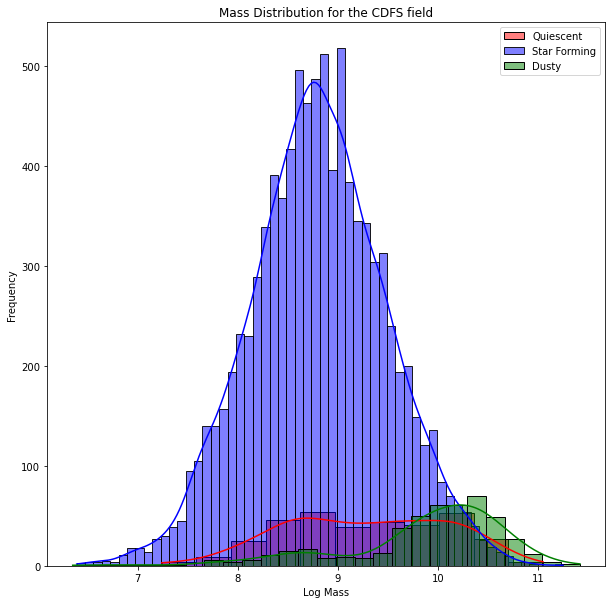

In [58]:
# We are now going to plot distributions for each of the populations of their mass
# with a seperate distribution for each of the populations

# First an overall plot
plt.figure(figsize=(10, 10))
sns.histplot(df[df['GalaxyType'] == 0]['lmass'], kde=True
                , color='r', label='Quiescent')
sns.histplot(df[df['GalaxyType'] == 1]['lmass'], kde=True
                , color='b', label='Star Forming')
sns.histplot(df[df['GalaxyType'] == 2]['lmass'], kde=True
                , color='g', label='Dusty')
plt.xlabel('Log Mass')
plt.ylabel('Frequency')
plt.title('Mass Distribution for the CDFS field')
plt.legend()
plt.show()



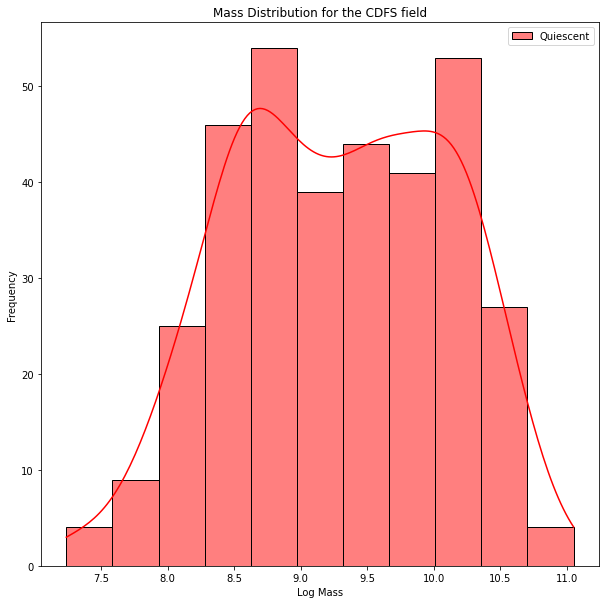

In [59]:
# Quiescent
plt.figure(figsize=(10, 10))
sns.histplot(df[df['GalaxyType'] == 0]['lmass'], kde=True
                , color='r', label='Quiescent')
plt.xlabel('Log Mass')
plt.ylabel('Frequency')
plt.title('Mass Distribution for the CDFS field')
plt.legend()
plt.show()

# Mean and Standard Deviation for the Quiescent Galaxies
quiescent_mean = df[df['GalaxyType'] == 0]['lmass'].mean()
quiescent_std = df[df['GalaxyType'] == 0]['lmass'].std()

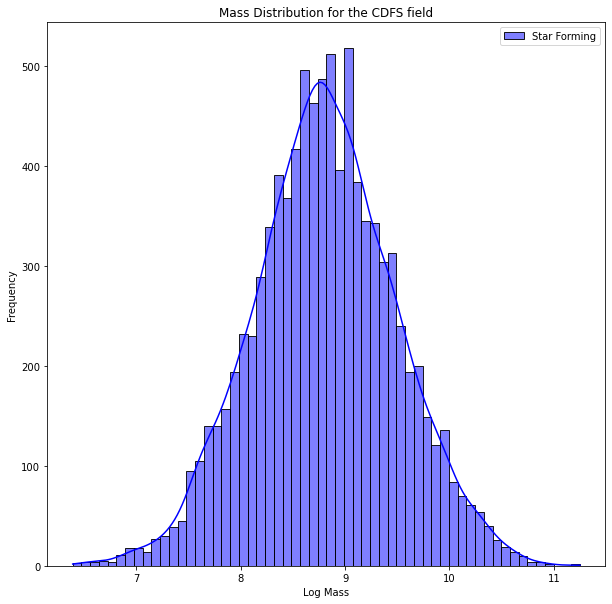

In [60]:
#Star-forming
plt.figure(figsize=(10, 10))
sns.histplot(df[df['GalaxyType'] == 1]['lmass'], kde=True
                , color='b', label='Star Forming')
plt.xlabel('Log Mass')
plt.ylabel('Frequency')
plt.title('Mass Distribution for the CDFS field')
plt.legend()
plt.show()

# Mean and Standard Deviation for the Star Forming Galaxies
star_forming_mean = df[df['GalaxyType'] == 1]['lmass'].mean()
star_forming_std = df[df['GalaxyType'] == 1]['lmass'].std()


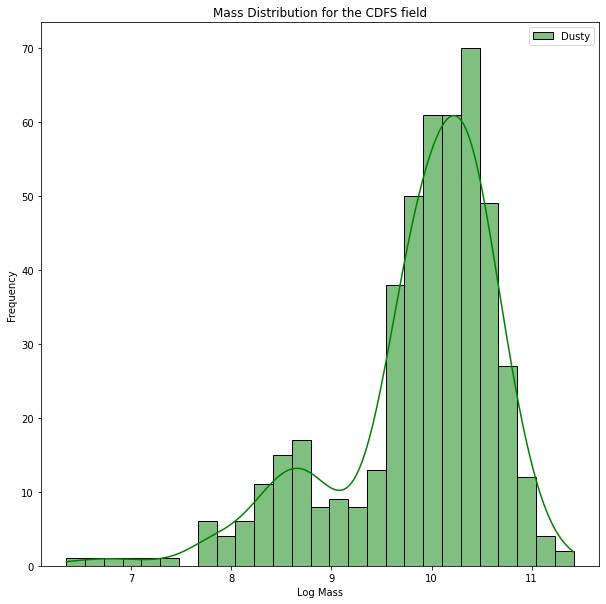

In [61]:
# Dusty
plt.figure(figsize=(10, 10))
sns.histplot(df[df['GalaxyType'] == 2]['lmass'], kde=True
                , color='g', label='Dusty')
plt.xlabel('Log Mass')
plt.ylabel('Frequency')
plt.title('Mass Distribution for the CDFS field')
plt.legend()
plt.show()

# Mean and Standard Deviation for the Dusty Galaxies
dusty_mean = df[df['GalaxyType'] == 2]['lmass'].mean()
dusty_std = df[df['GalaxyType'] == 2]['lmass'].std()